In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/CORONA_dataset_0-month_3-month-target.csv')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 70 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UNMC_id             1229 non-null   object 
 1   grp                 1229 non-null   object 
 2   init_group          1229 non-null   object 
 3   CDate               1229 non-null   object 
 4   futime              1229 non-null   int64  
 5   age                 1228 non-null   float64
 6   gender              1228 non-null   object 
 7   final_education     1224 non-null   object 
 8   race_grp            1229 non-null   object 
 9   ethnicity           1210 non-null   float64
 10  weight              1228 non-null   float64
 11  BMI                 1228 non-null   float64
 12  height              1229 non-null   int64  
 13  newsmoker           1208 non-null   object 
 14  smkyrs              349 non-null    float64
 15  numcigs             341 non-null    float64
 16  drinke

In [3]:
columns_drop = df.isnull().mean()[df.isnull().mean() > 0.7].index
columns_drop
df = df.drop(['UNMC_id', 'CDate', 'futime', 'response_status', 'response_encoded', 'DAS_28_0', 'DAS_28_3' ], axis=1)
df = df.drop(columns_drop, axis=1)

In [4]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()

columns_to_encode = ['grp', 'init_group', 'gender', 'newsmoker', 'drinker', 'ara_func_class', 'final_education', 'race_grp']

# Using .fit_transform function to fit label
for column in columns_to_encode:
    df[column] = le.fit_transform(df[column])


In [5]:
from sklearn.impute import KNNImputer

# Create a KNN imputer object
imputer = KNNImputer(n_neighbors=30)

# Impute missing values using KNN
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# df['response_encoded'] = df['response_encoded'].round().astype(int)


In [6]:
def calculate_DAS28_CRP_0(row):
    DAS28_CRP = 0.56*math.sqrt(row['tender_jts_28_0']) + 0.28*math.sqrt(
        row['swollen_jts_28_0']) + 0.014*row['pt_global_assess_0'] + 0.36*np.log(row['usresultsCRP_0']+1) + 0.96
    return DAS28_CRP

In [7]:
def calculate_DAS28_CRP_3(row):
    DAS28_CRP = 0.56*math.sqrt(row['tender_jts_28_3']) + 0.28*math.sqrt(
        row['swollen_jts_28_3']) + 0.014*row['pt_global_assess_3'] + 0.36*np.log(row['usresultsCRP_3']+1) + 0.96
    return DAS28_CRP

In [8]:
df['DAS_28_0'] = df.apply(calculate_DAS28_CRP_0, axis=1)
df['DAS_28_3'] = df.apply(calculate_DAS28_CRP_3, axis=1)

In [9]:
def responseClassify(row, baseline='DAS_28_0', next='DAS_28_3'):
    # set threshold
    lower_change = 0.6
    upper_change = 1.2
    change = row[baseline] - row[next]
    if change <= lower_change:
        return "No Response"
    elif (change <= upper_change) & (change > lower_change):
        if row[next] > 5.1:
            return "No Response"
        else:
            return "Moderate"
    elif change > upper_change:
        if row[next] > 3.2:
            return "Moderate"
        else:
            return "Good"
    else:
        return "Unknown"

In [10]:
df['response_status'] = df.apply(responseClassify, axis=1)


In [11]:
value_counts = df['response_status'].value_counts()
print(value_counts)

Moderate       450
No Response    407
Good           372
Name: response_status, dtype: int64


In [12]:
encoding_mapping = {'Moderate': 2, 'Good': 3, 'No Response': 1}

# Apply manual encoding and store the result in a new column
df['response_encoded'] = df['response_status'].map(encoding_mapping)

In [13]:
df = df.drop(['tender_jts_28_3', 'swollen_jts_28_3', 'pt_global_assess_3', 'usresultsCRP_3', 'DAS_28_0', 'DAS_28_3', 'weight', 'pt_pain', 'ccpstatus_b', 'response_status' ], axis=1)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   grp                 1229 non-null   float64
 1   init_group          1229 non-null   float64
 2   age                 1229 non-null   float64
 3   gender              1229 non-null   float64
 4   final_education     1229 non-null   float64
 5   race_grp            1229 non-null   float64
 6   ethnicity           1229 non-null   float64
 7   BMI                 1229 non-null   float64
 8   height              1229 non-null   float64
 9   newsmoker           1229 non-null   float64
 10  drinker             1229 non-null   float64
 11  drinksperwk         1229 non-null   float64
 12  duration_ra         1229 non-null   float64
 13  ara_func_class      1229 non-null   float64
 14  num_tnf             1229 non-null   float64
 15  num_nontnf          1229 non-null   float64
 16  ndmard

In [117]:
# df = df.fillna(df.median())

In [ ]:
# y = df['response_status']

In [ ]:
# X = df.drop(['response_status'], axis=1)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [ ]:
# train_data = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
# test_data = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
!pip install h2o
import h2o
h2o.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp85_oaii8
  JVM stdout: /tmp/tmp85_oaii8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp85_oaii8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_1hblje
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [15]:
h2o_df = h2o.H2OFrame(df)

#preview
h2o_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


grp,init_group,age,gender,final_education,race_grp,ethnicity,BMI,height,newsmoker,drinker,drinksperwk,duration_ra,ara_func_class,num_tnf,num_nontnf,ndmardused,rfstatus_b,usresultsRF,usresultsCCP3,hxmi,hxunstab_ang,hxchf,hxother_cv,hxtia,hxstroke,hxcopd,hxhtn,hxdiabetes,hxhld,hx_anycancer,seatedbp1,seatedbp2,pres_mtx,pres_arava,pres_azulfidine,pres_plaquenil,pres_imuran,pres_minocin,pres_pred,nonpresNSAIDs_use,NSAIDs_use,md_global_assess,di,usresultsIgA,usresultsIgG,usresultsIgM,tender_jts_28_0,swollen_jts_28_0,pt_global_assess_0,usresultsCRP_0,response_encoded
4,0,59,0,0,7,0.966667,33.9829,64,0,0,0,11,1,3,1,3,1,18.2,19,0,0,0,0,0,0,0,1,0,0,0,128,82,0,0,0,0,0,0,0,1,0,50,1.375,207,826,24,27,6,55,17.13,2
4,0,51,0,0,7,1,20.2204,68,2,1,0.233333,9,2,1,0,2,1,339.8,251,0,0,0,0,0,0,0,0,0,0,0,140,90,0,0,0,0,0,0,1,1,0,70,1.28571,469,1260,114,8,10,90,5.56,2
2,1,54,1,0,7,1,31.3777,71,2,1,0.7,7,0,0,0,2,1,56.4,15,0,0,0,0,0,0,0,0,0,0,0,122,88,0,0,0,1,0,0,0,0,1,50,0.285714,144,886,113,3,4,25,1.64,3
0,0,67,0,0,7,1,21.609,63,2,0,0,10,1,2,1,3,0,12.7,177,0,0,0,1,0,0,0,1,0,0,0,143,68,0,1,0,0,0,0,1,1,1,50,0.25,342,752,60,9,10,40,0.43,1
6,0,68,0,0,7,1,20.0149,63,2,0,0,11,1,2,2,3,1,20.9,242,0,0,0,1,0,0,0,1,0,0,0,130,71,0,0,0,0,0,0,1,1,0,50,0.142857,338,714,66,6,8,20,49.55,2
6,0,63,0,0,7,1,20.939,64,0,1,3,5,1,1,1,2,0,8.2,15,0,0,0,0,0,0,0,0,0,0,0,113,68,1,0,0,0,0,0,1,0,1,35,0,179,1210,176,4,8,70,0.19,3
0,0,70,0,2,7,1,22.8475,60,0,0,0,44,1,3,0.433333,2,1,813,251,1,0,0,0,0,0,0,0,0,0,1,118,80,1,0,0,0,0,0,0,0,1,65,2,523,1310,279,6,10,95,17.73,3
4,0,63,1,0,7,1,37.9481,69,2,1,2,5,1,1,0.333333,2,1,446.1,251,1,0,0,0,0,0,0,1,0,0,0,99,64,1,0,0,0,0,0,0,1,0,40,0.125,207,1110,247,17,2,25,3.53,1
6,0,64,1,0,7,1,37.5051,69,2,1,0.466667,6,1,1,1,2,1,1153,251,1,0,0,0,0,0,0,1,0,0,0,112,70,0,0,0,0,0,0,0,0,0,35,0,238,1080,291,11,4,30,2.41,2
0,0,47,0,2,7,1,26.0879,64,1,1,2,22,0,2,0.233333,1,1,119,251,0,0,0,0,0,0,0,0,0,0,0,118,60,0,0,0,0,0,0,0,0,0,35,0,153,1200,262,1,6,55,1.81,1


In [16]:
train, test = h2o_df.split_frame(ratios=[0.75], seed=121)
#define X and y
X = train.columns
y = 'response_encoded'
X.remove(y)

In [17]:
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [18]:
from h2o.automl import H2OAutoML

# aml = H2OAutoML(max_models=20, seed=1, nfolds=5,
#                                  keep_cross_validation_predictions=True)

# aml = H2OAutoML(max_models=20, 
#                 seed=121, 
#                 stopping_metric='AUC',     #for classification
#                 nfolds=5, 
#                 balance_classes=True,
#                 keep_cross_validation_predictions=True)

aml = H2OAutoML(max_models=20, 
                seed=121, 
                nfolds=5, 
                balance_classes=True,
                keep_cross_validation_predictions=True,
                max_runtime_secs=3600)

aml.train(x=X, 
          y=y, 
          training_frame=train)


# aml.train(x=X_train.columns.to_list(), y='response_status', training_frame=train_data)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_1_20230511_142216_model_2


Model Summary: 
    number_of_trees
--  -----------------
    30

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.1529819009431445
RMSE: 0.39112900805635026
LogLoss: 0.4796507059966751
Mean Per-Class Error: 0.08646120069460735
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
1    2    3    Error      Rate
---  ---  ---  ---------  --------
280  14   10   0.0789474  24 / 304
17   310  12   0.0855457  29 / 339
13   13   248  0.0948905  26 / 274
310  337  270  0.0861505  79 / 917

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.91385
2    0.990185
3    1

ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.3910865617373029
RMSE: 0.6253691403781473
LogLoss: 1.062315889061878
Mean Per-Class Error: 0.5163560000543961
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
1    2    3    Error     Rate
---  ---  ---  --------  ---------
147  98   59   0.516447  157 / 304
76   177  86   0.477876  162 / 339
65   87   122  0.554745  152 / 274
288  362  267  0.513631  471 / 917

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.486369
2    0.776445
3    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.486368  0.0232634   0.48913       0.483696      0.453552      0.519126      0.486339
auc                      nan       0           nan           nan           nan           nan           nan
err                      0.513632  0.0232634   0.51087       0.516304      0.546448      0.480874      0.513661
err_count                94.2      4.26615     94            95            100           88            94
logloss                  1.0623    0.026946    1.10484       1.03724       1.04767       1.04973       1.072
max_per_class_error      0.563931  0.0371684   0.566667      0.566038      0.622641      0.537037      0.527273
mean_per_class_accuracy  0.485232  0.0230845   0.489236      0.482692      0.450739      0.515419      0.488073
mean_per_class_error     0.514768  0.0230845   0.510764      0.517308      0.549261      0.484581      0.511927
mse                      0.391075  0.00666344  0.402456      0.390117      0.389378      0.384951      0.388474
pr_auc                   nan       0           nan           nan           nan           nan           nan
r2                       0.37626   0.0324885   0.402388      0.335222      0.405061      0.390871      0.347759
rmse                     0.625342  0.00530473  0.634394      0.624594      0.624002      0.620444      0.623277

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_logloss    training_classification_error    training_auc    training_pr_auc
--  -------------------  ----------  -----------------  ---------------  ------------------  -------------------------------  --------------  -----------------
    2023-05-11 14:23:38  4.032 sec   0                  0.666667         1.09861             0.7012           

In [19]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_grid_1_AutoML_1_20230511_142216_model_2,0.516356,1.06232,0.625369,0.391087
StackedEnsemble_AllModels_1_AutoML_1_20230511_142216,0.518525,1.02645,0.632376,0.3999
GBM_4_AutoML_1_20230511_142216,0.519154,1.04156,0.630452,0.39747
GBM_2_AutoML_1_20230511_142216,0.521058,1.03787,0.628836,0.395435
XGBoost_grid_1_AutoML_1_20230511_142216_model_3,0.523344,1.05326,0.629144,0.395822
XGBoost_1_AutoML_1_20230511_142216,0.524038,1.08277,0.630556,0.397601
StackedEnsemble_BestOfFamily_1_AutoML_1_20230511_142216,0.527141,1.02922,0.632725,0.400341
GBM_3_AutoML_1_20230511_142216,0.5284,1.04977,0.633335,0.401113
GBM_5_AutoML_1_20230511_142216,0.530204,1.05034,0.633916,0.40185
XGBoost_3_AutoML_1_20230511_142216,0.532787,1.11375,0.636449,0.405068


In [20]:
import matplotlib.pyplot as plt

# Assuming you already have the AutoML leaderboard object 'leaderboard'
leaderboard_df = lb.as_data_frame()

# Sort the leaderboard by F1 score in descending order
sorted_leaderboard = leaderboard_df.sort_values('F1', ascending=False)

# Extract the model names and F1 scores for top models
top_models = sorted_leaderboard.head(5)  # Adjust the number of top models as needed

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(top_models['model_id'], top_models['F1'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Top Models - F1 Scores')
plt.xticks(rotation=45)
plt.show()

KeyError: ignored

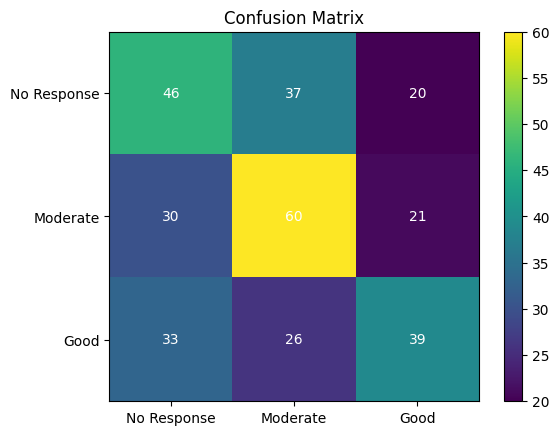

In [42]:
import numpy as np
import matplotlib.pyplot as plt

multiclass = np.array([[46,37,20],
                       [30,60,21],
                       [33,26,39]])

class_names = ['No Response', 'Moderate', 'Good']

fig, ax = plt.subplots()
im = ax.imshow(multiclass, cmap='viridis')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Loop over data dimensions and create text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, multiclass[i, j],
                       ha="center", va="center", color="w")

# Set a title
ax.set_title("Confusion Matrix")

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_grid_1_AutoML_1_20230511_142216_model_2

1,2,3,Error,Rate
46.0,37.0,20.0,0.5533981,57 / 103
30.0,60.0,21.0,0.4594595,51 / 111
33.0,26.0,39.0,0.6020408,59 / 98
109.0,123.0,80.0,0.5352564,167 / 312


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

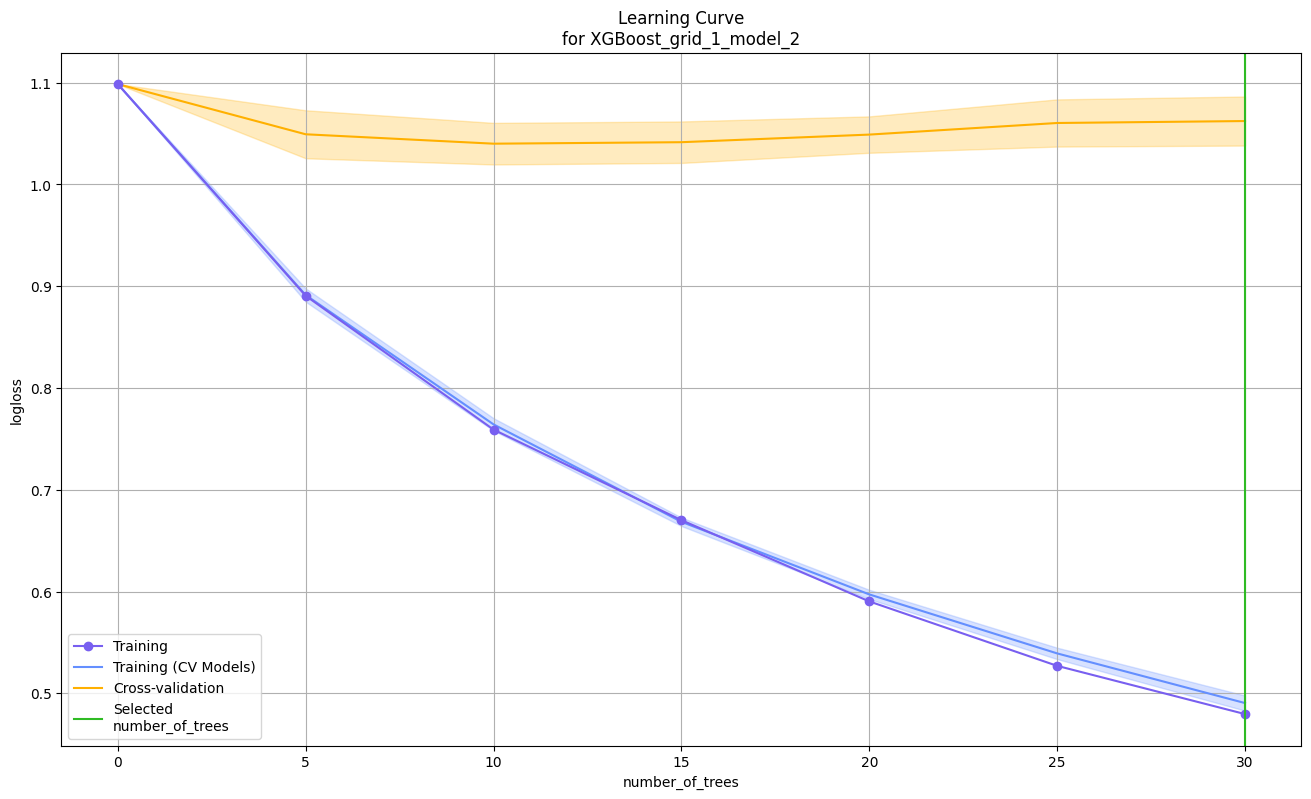

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

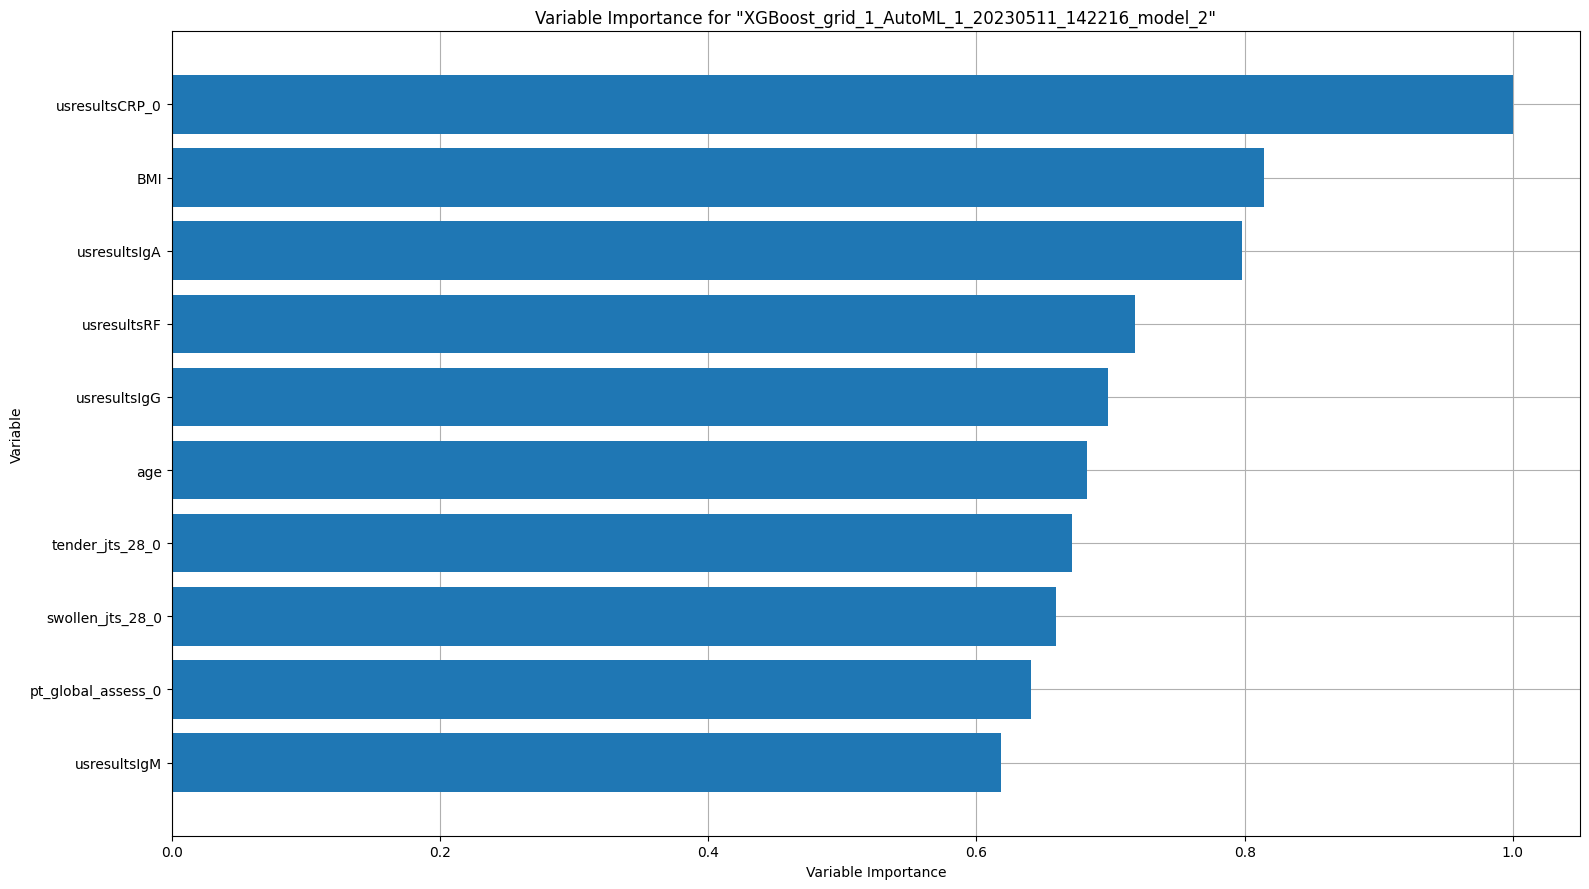

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

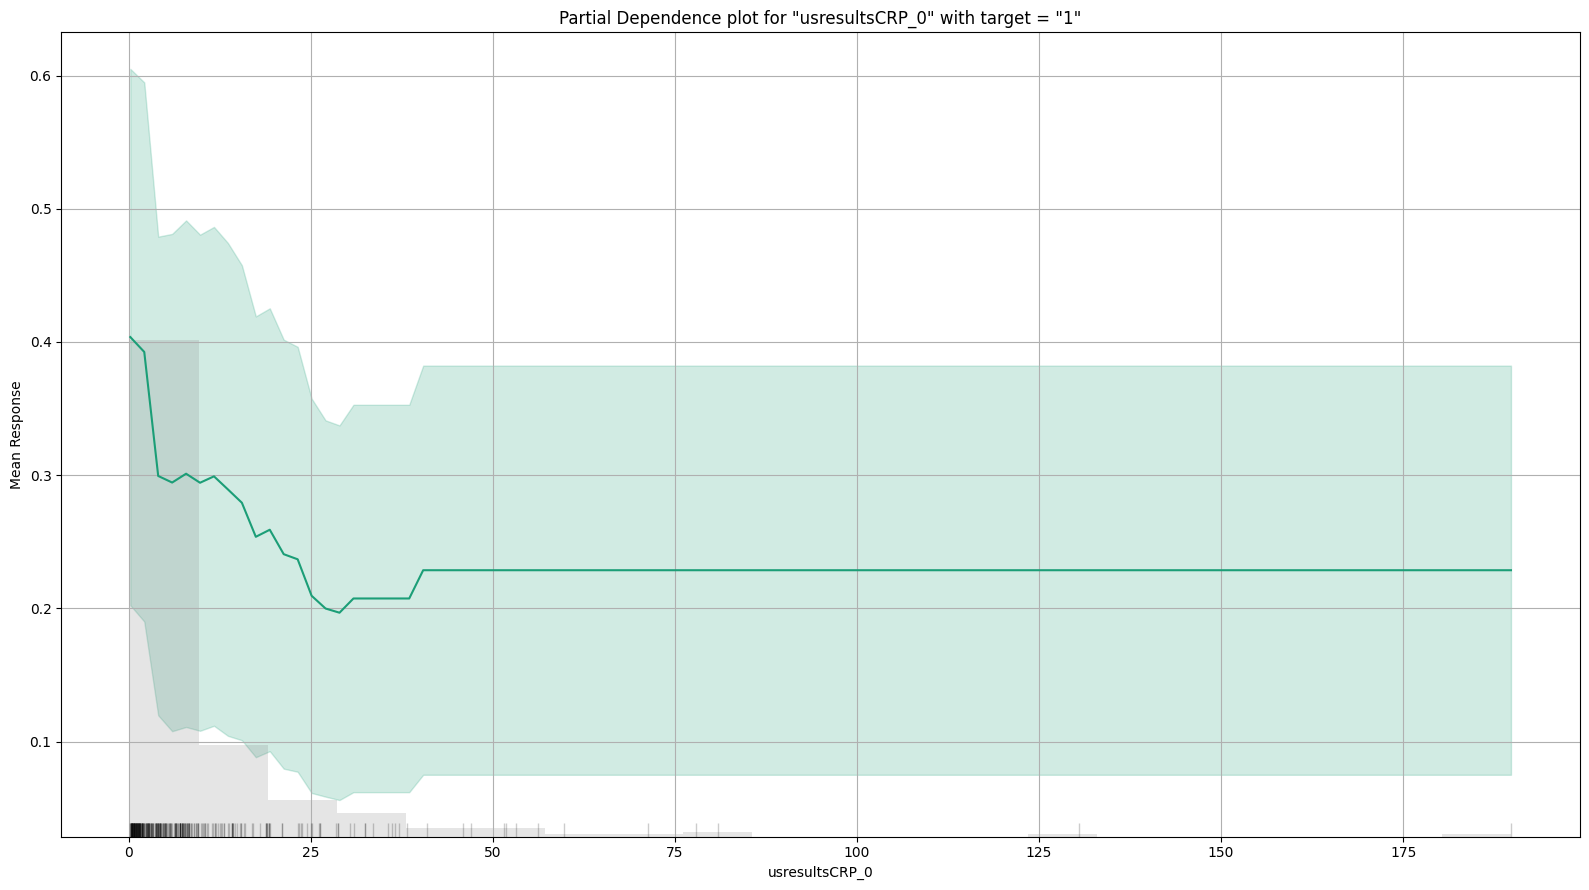

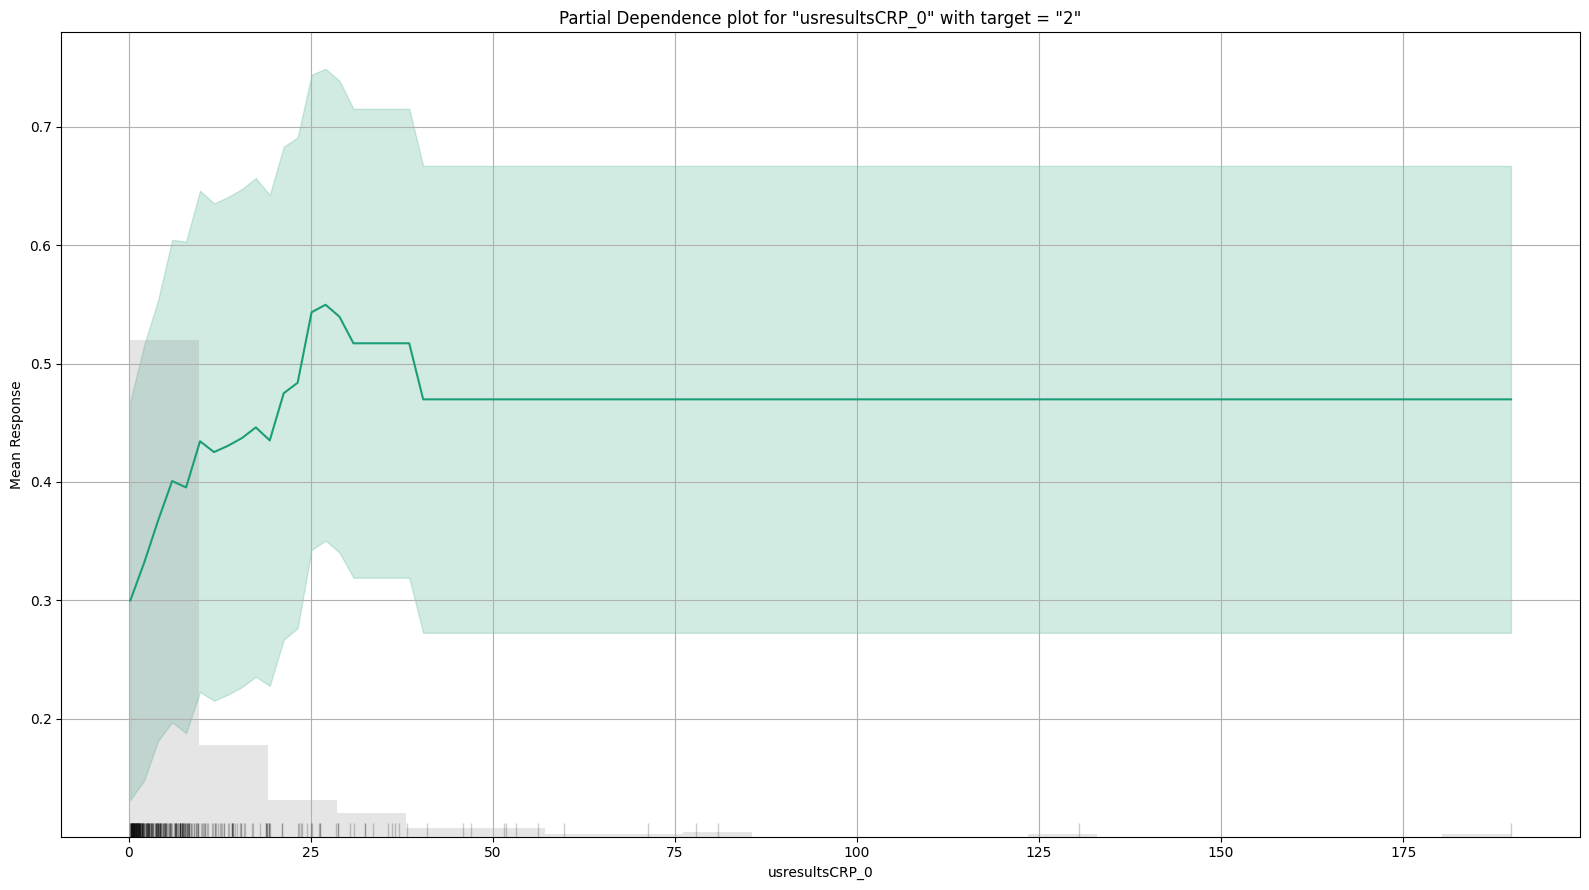

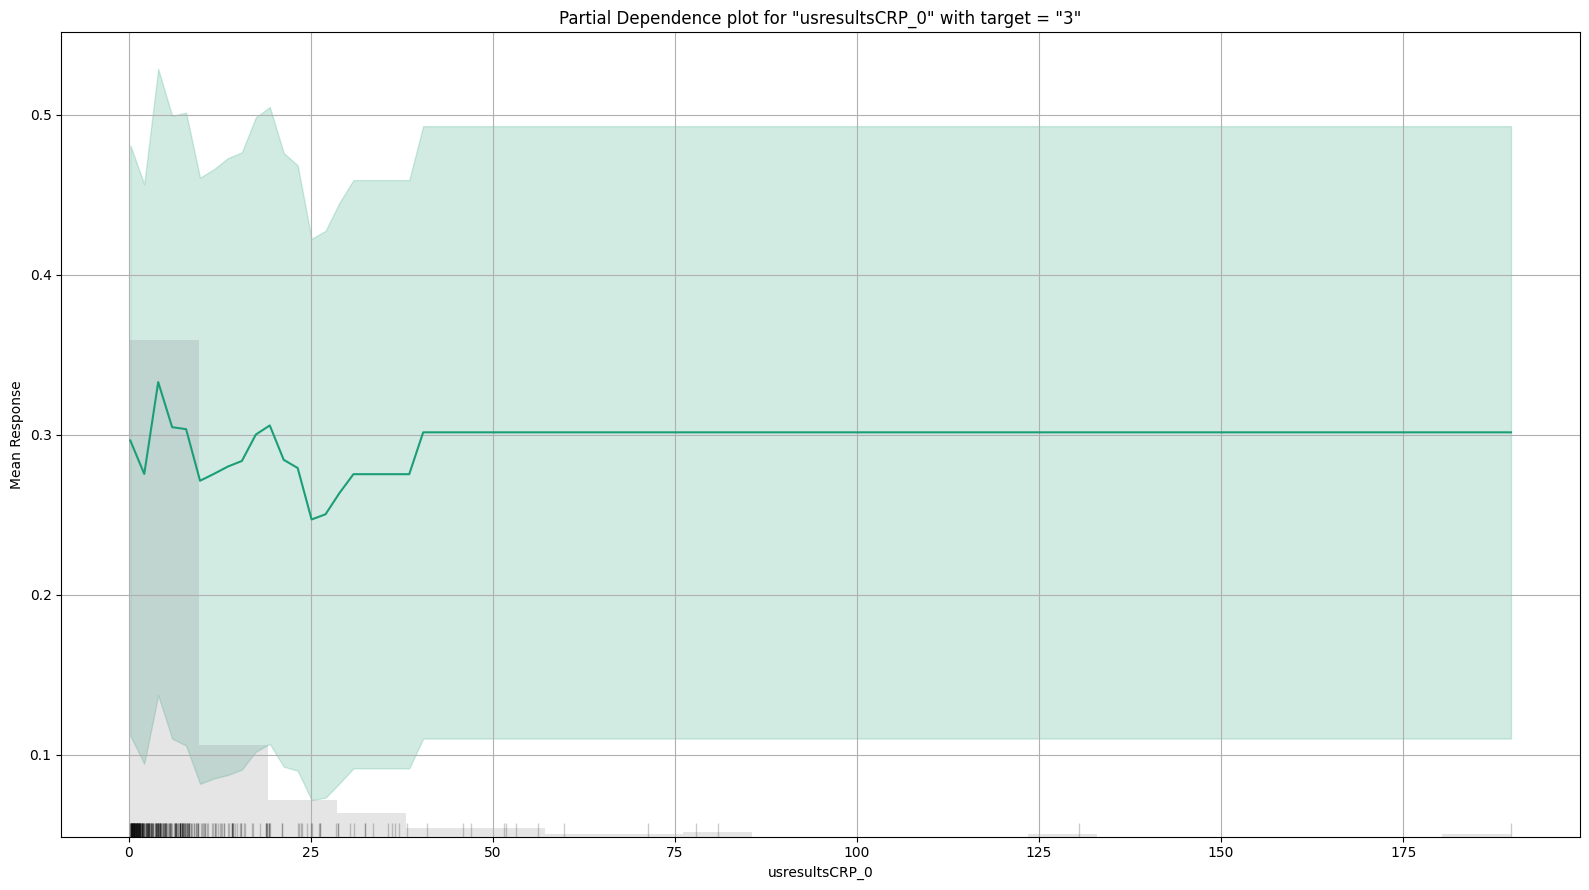

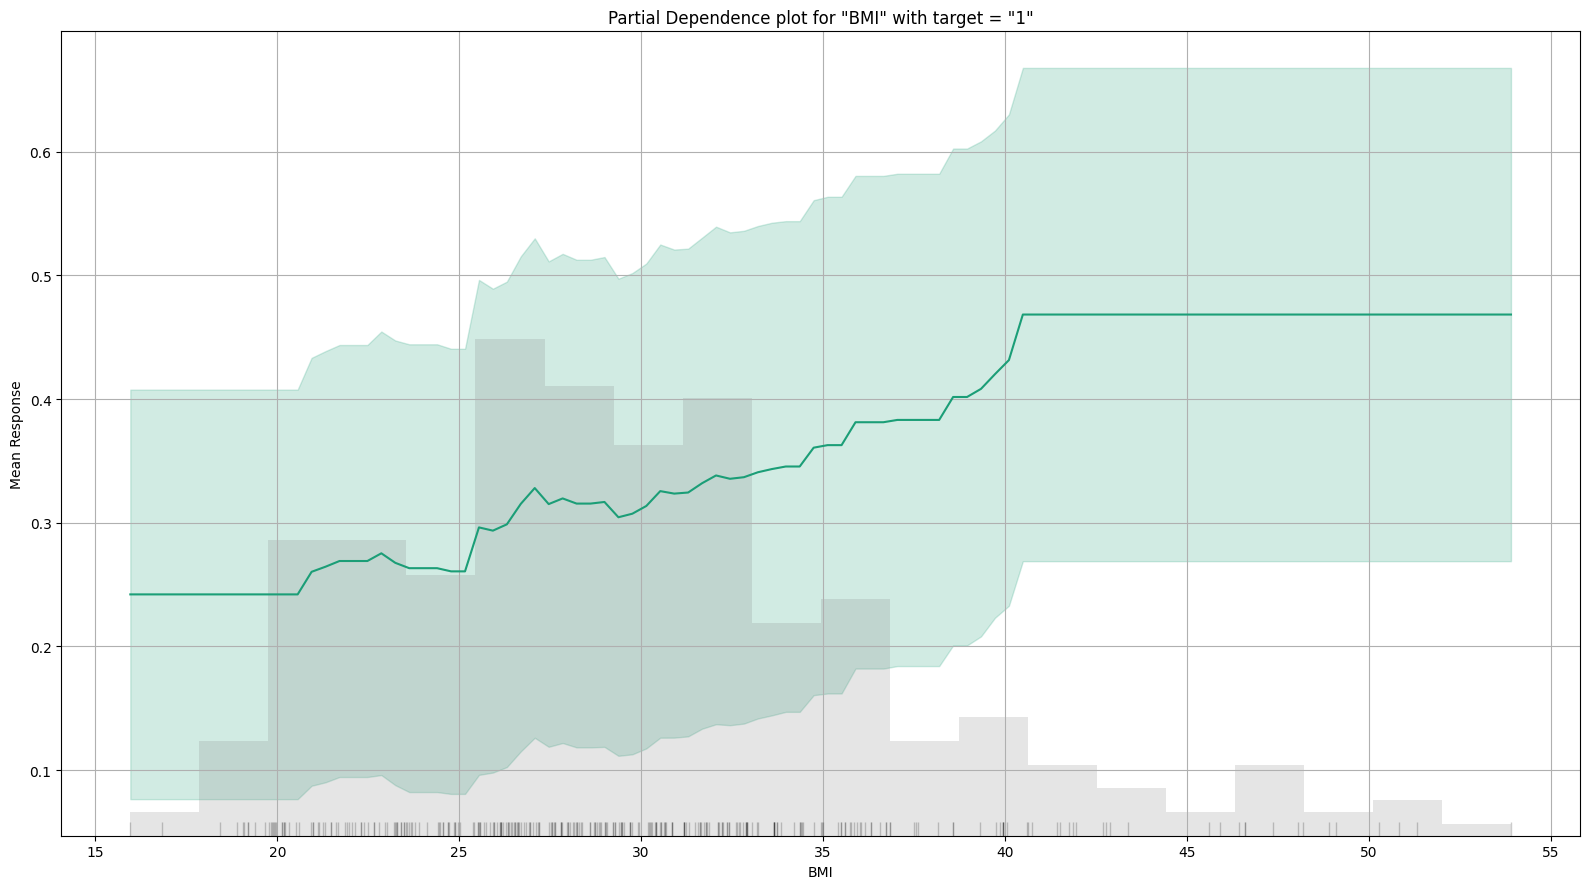

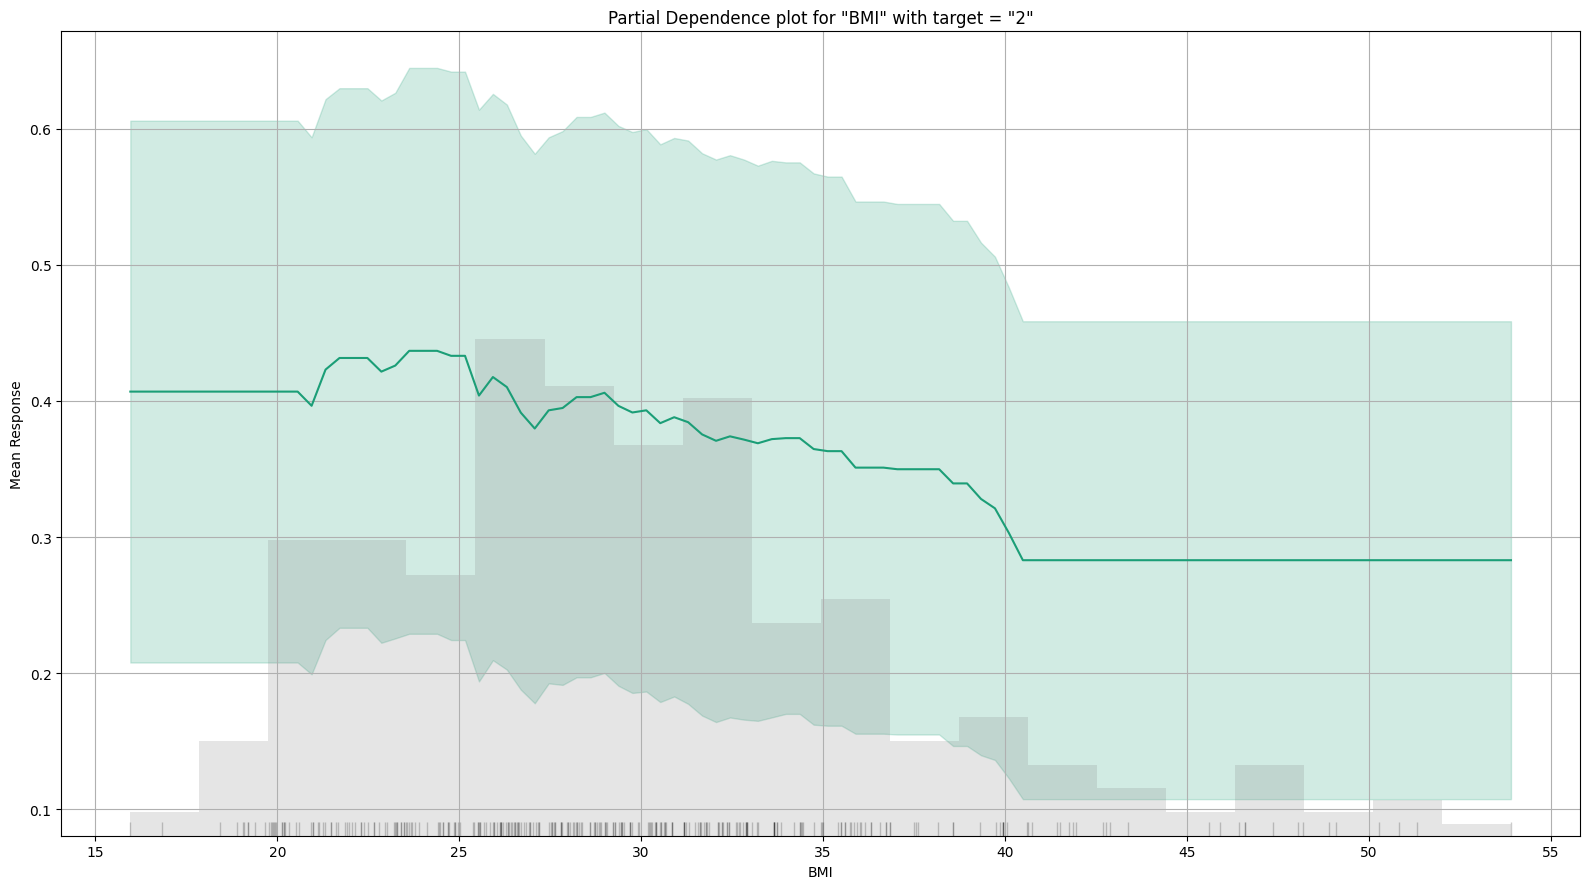

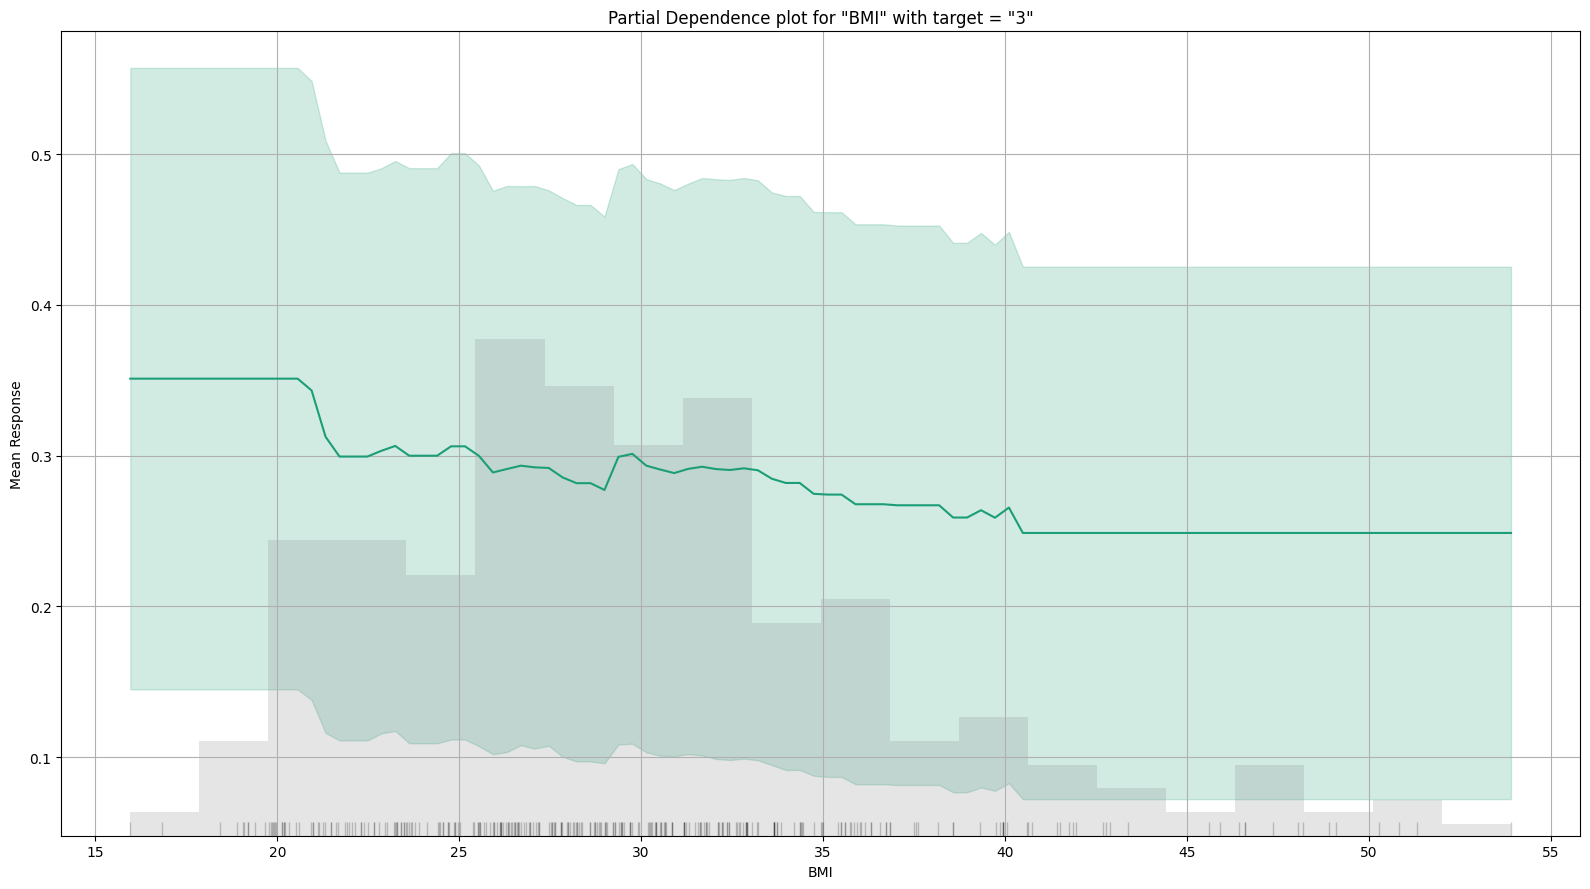

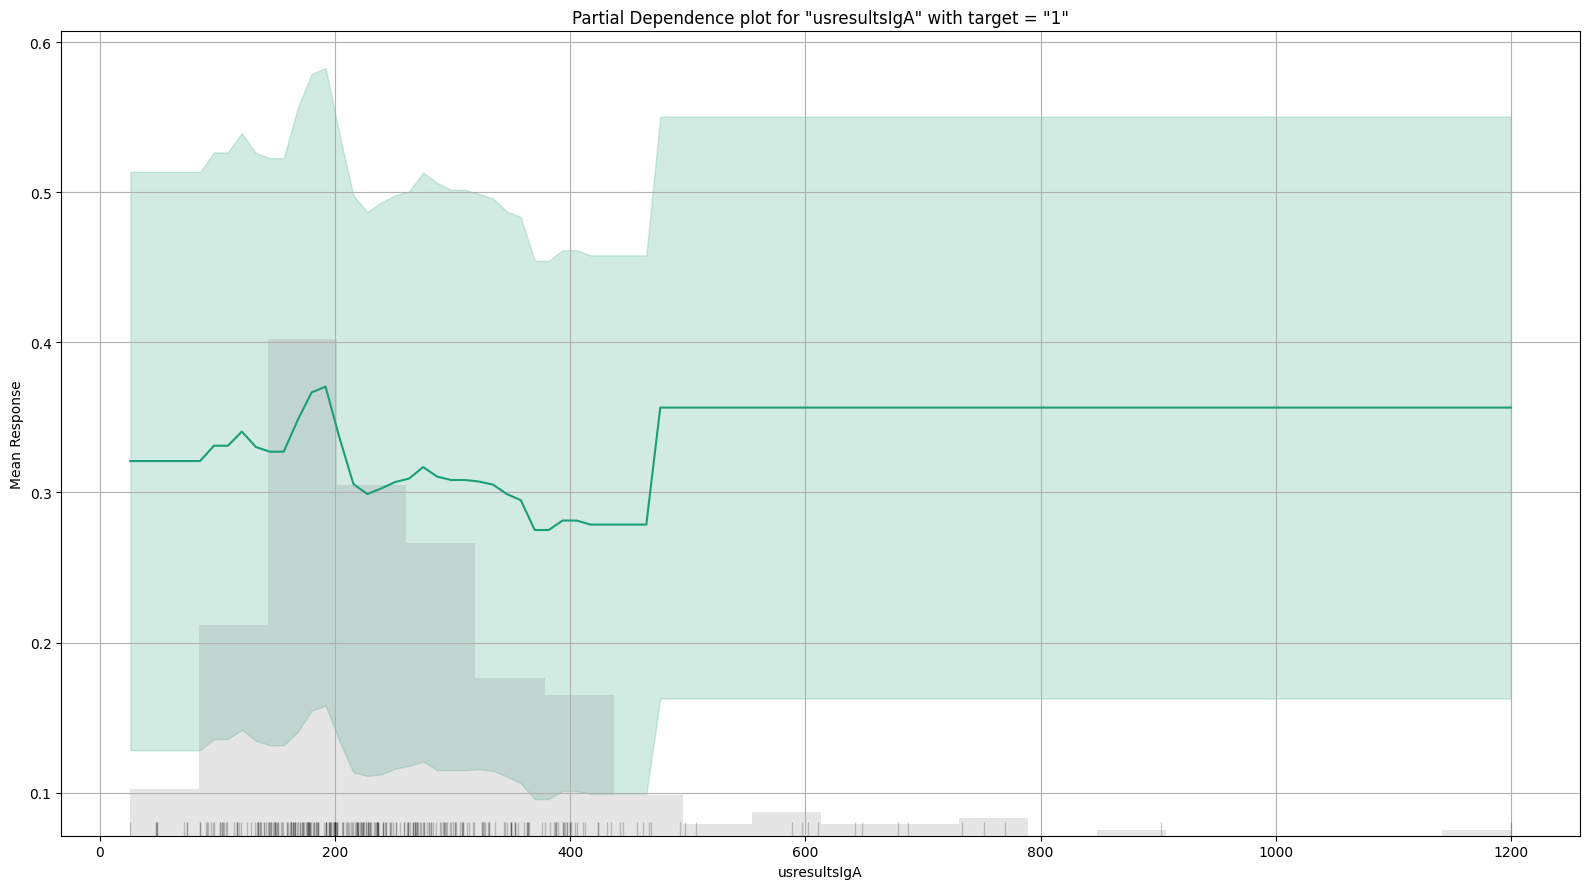

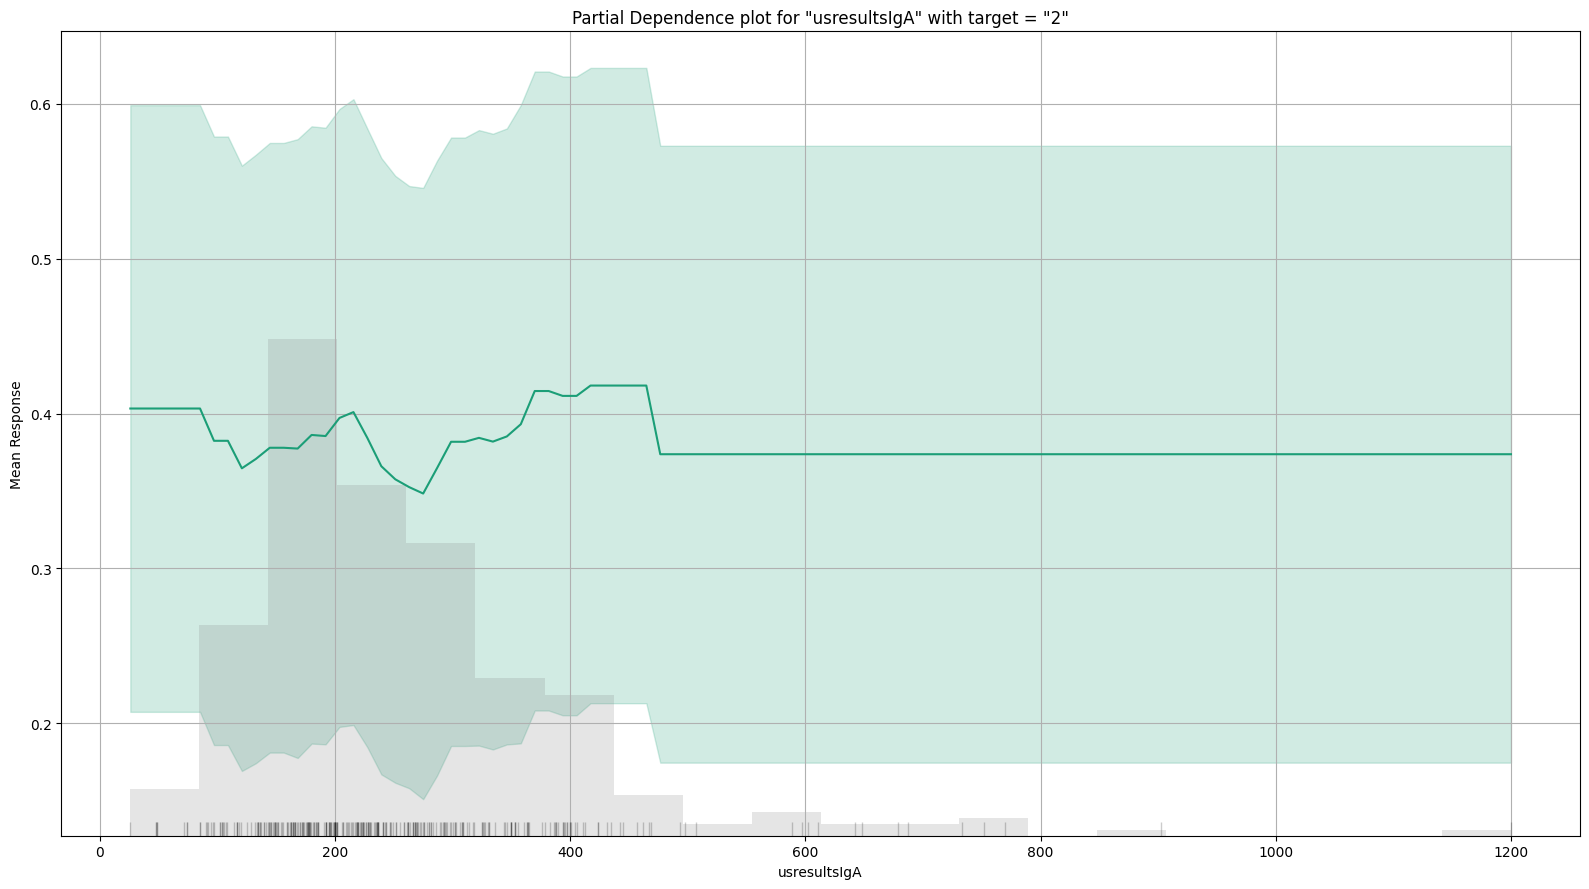

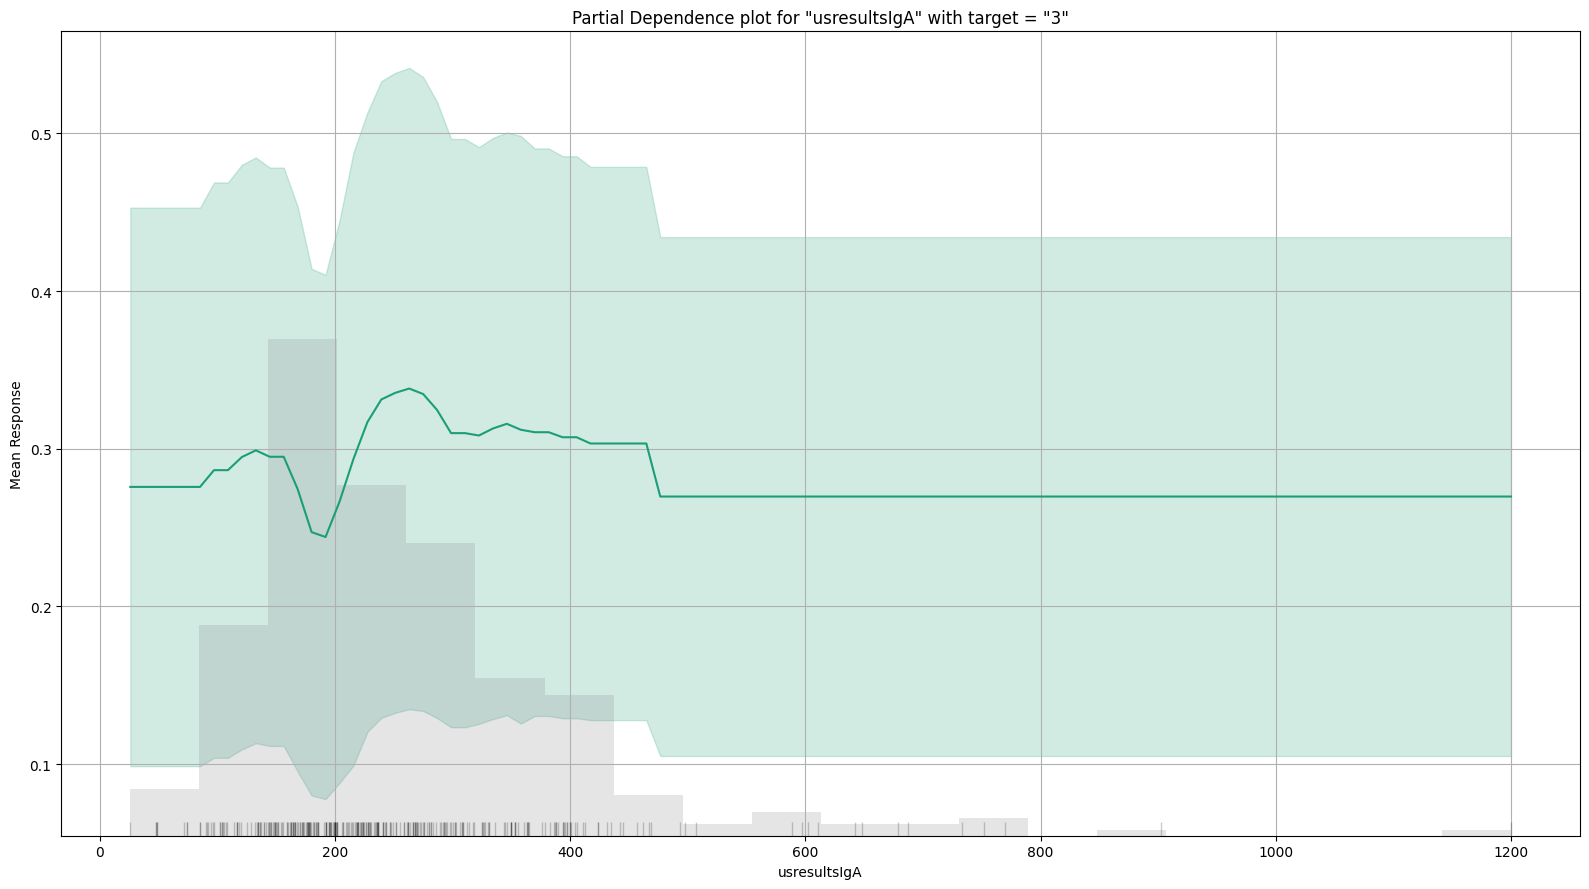

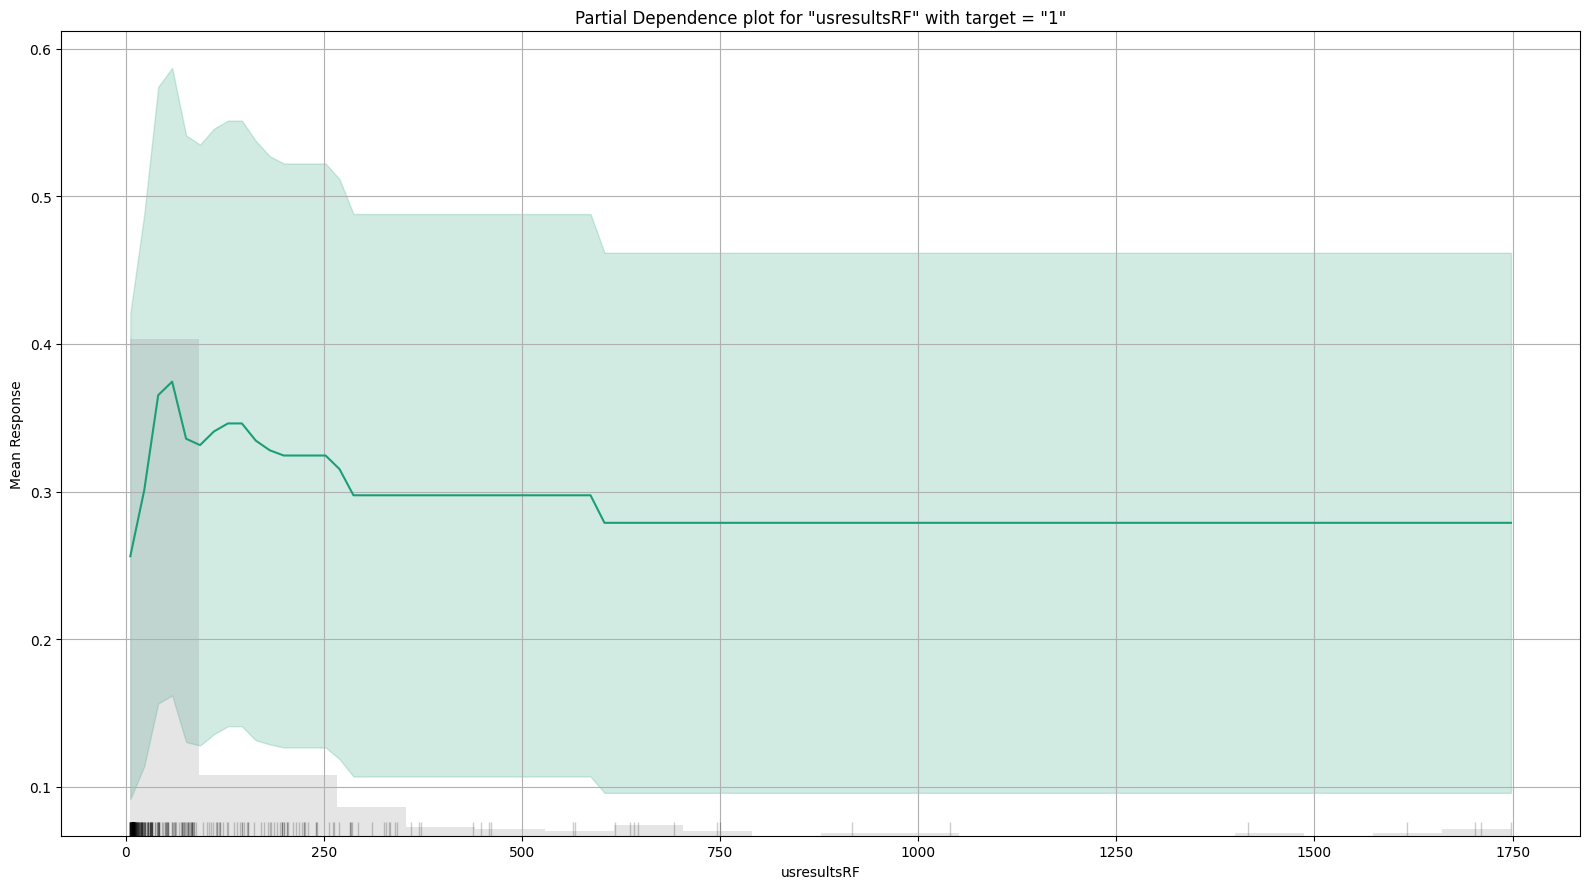

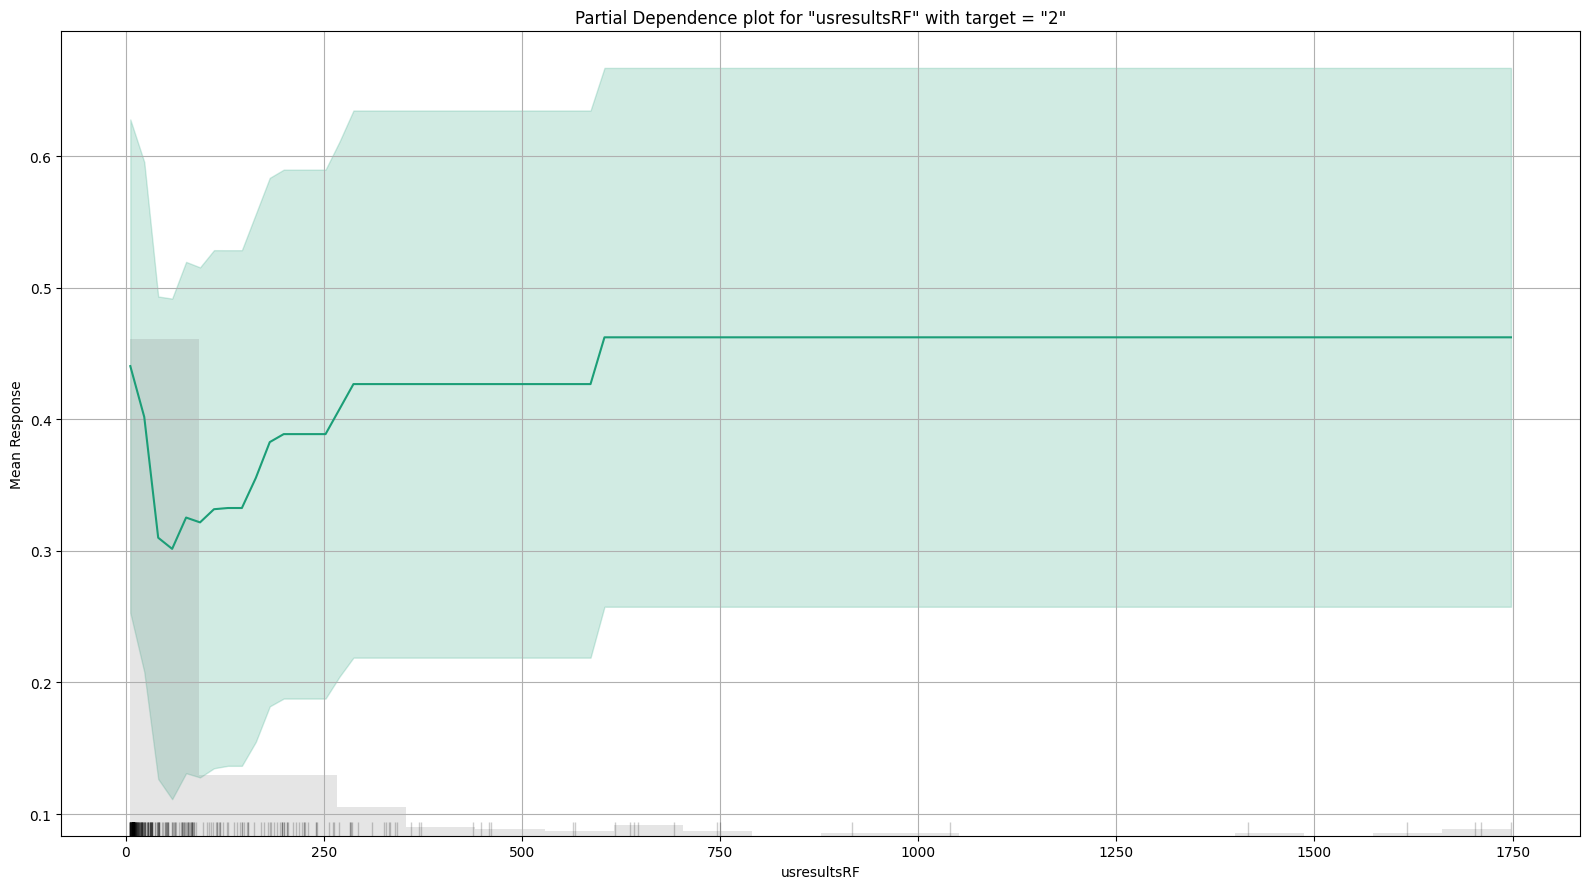

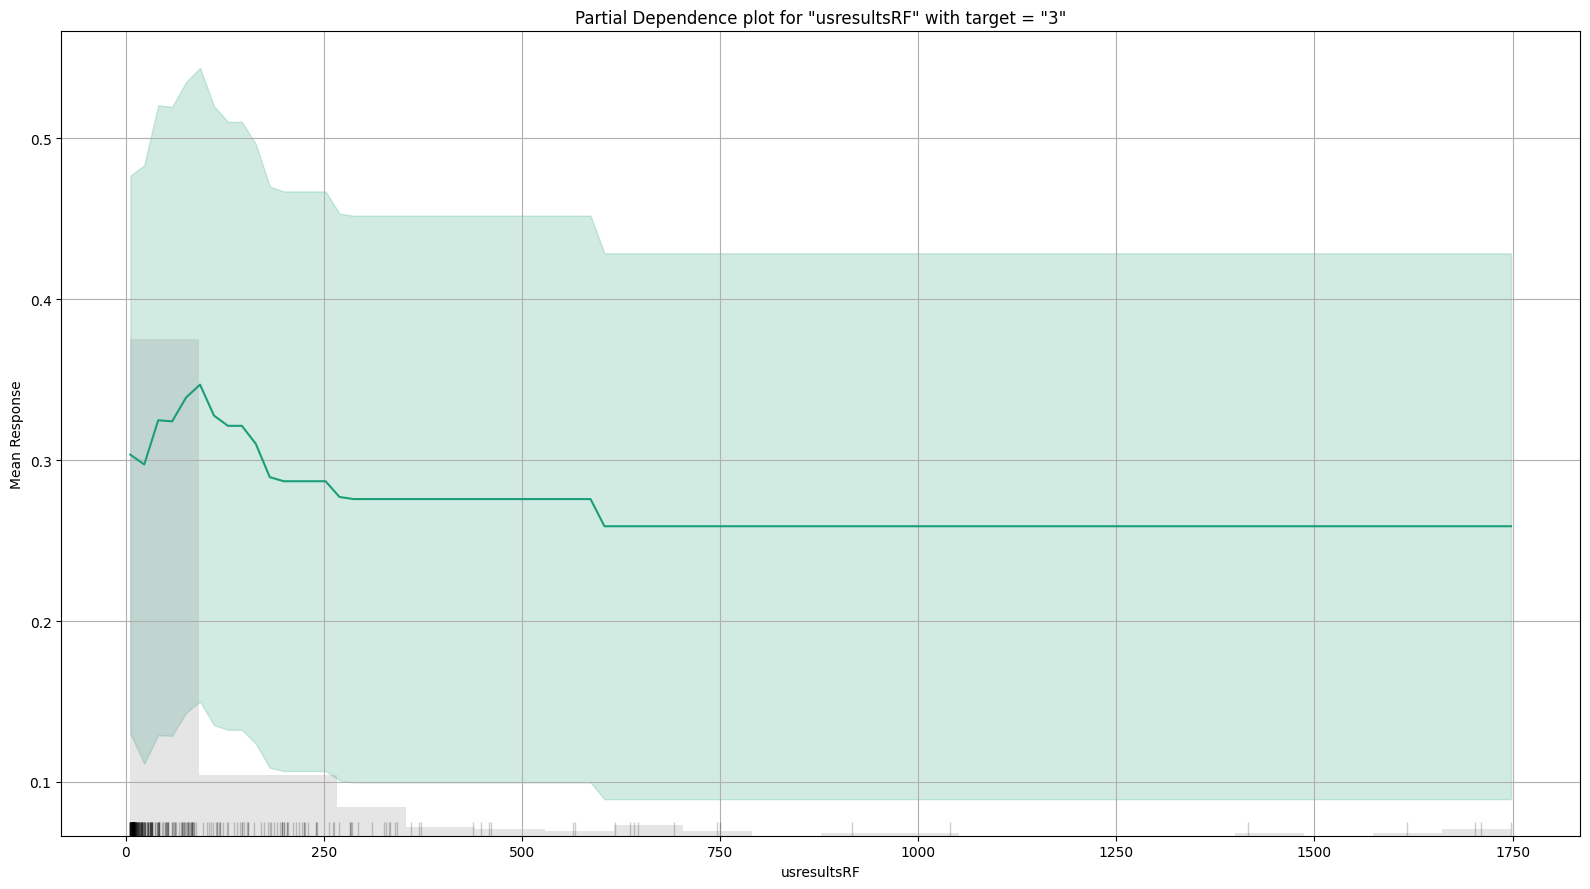

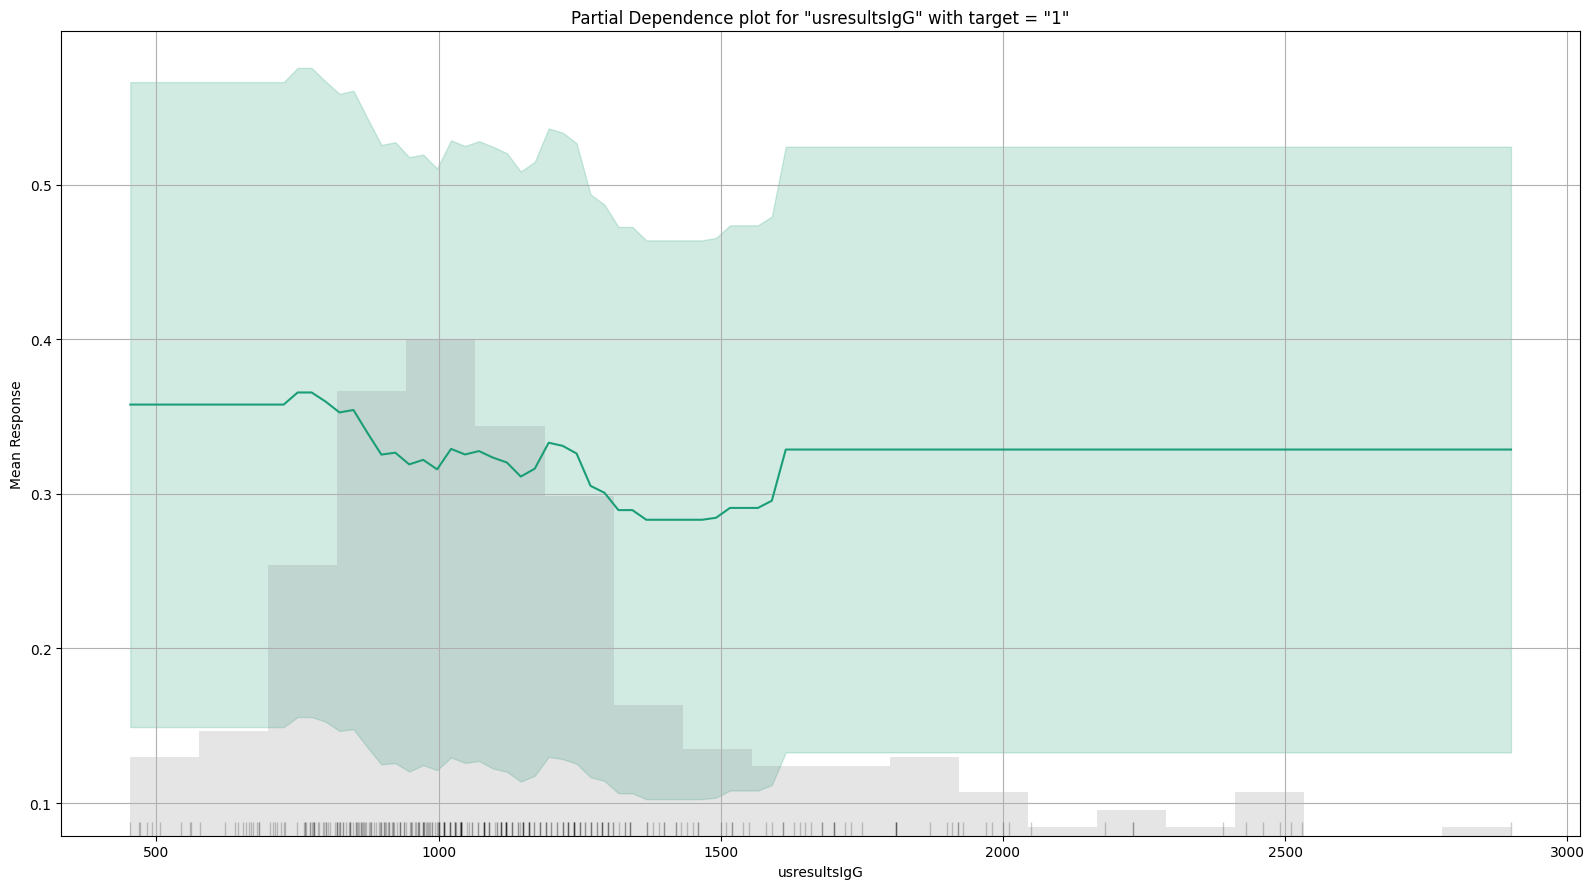

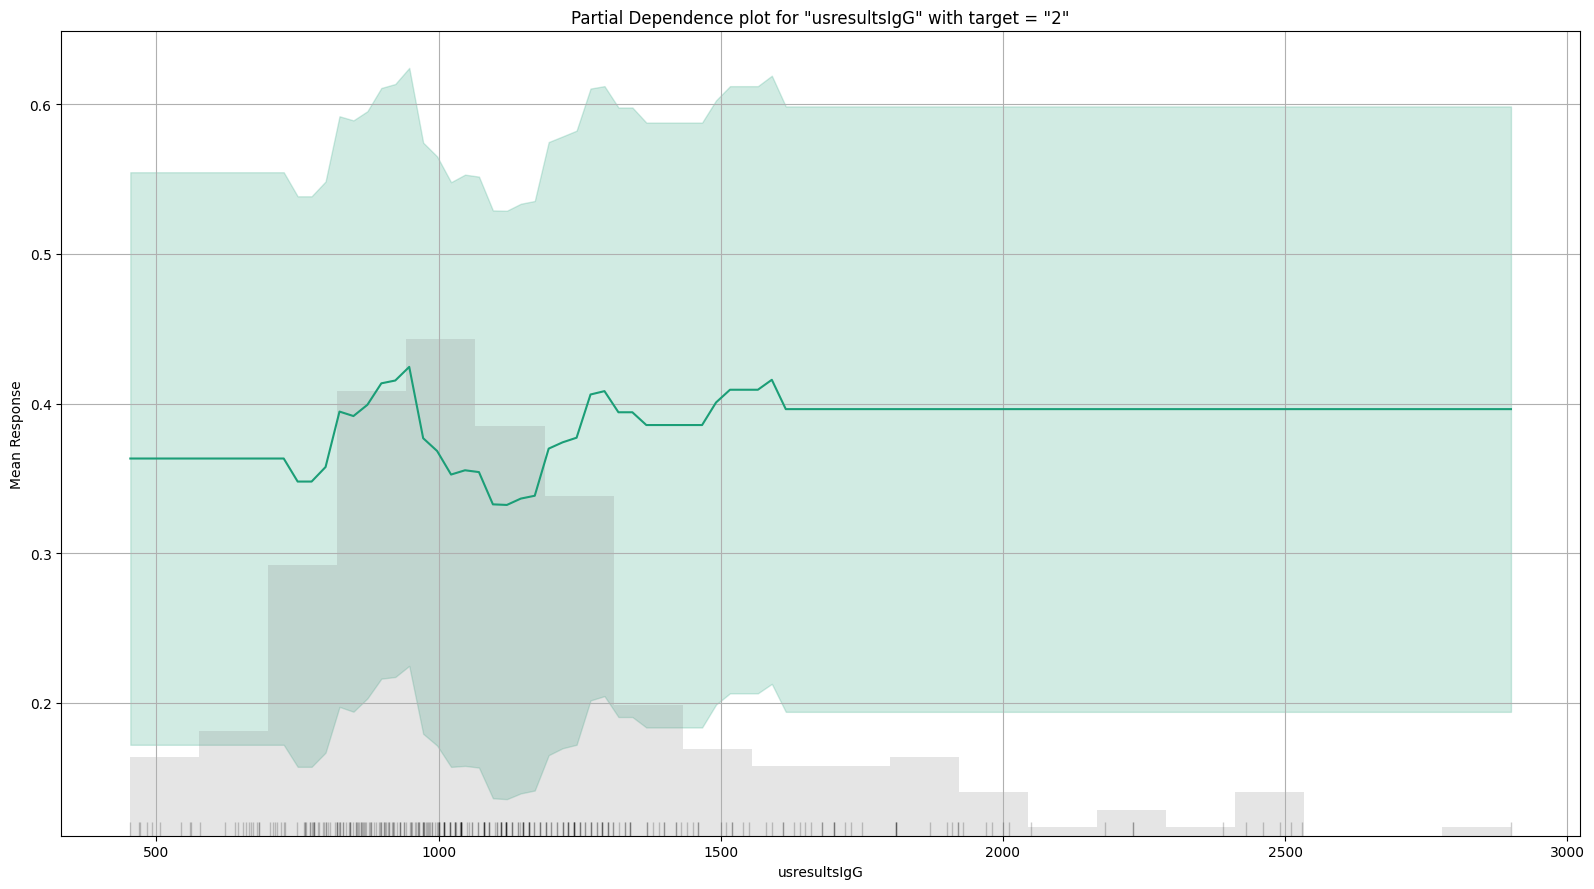

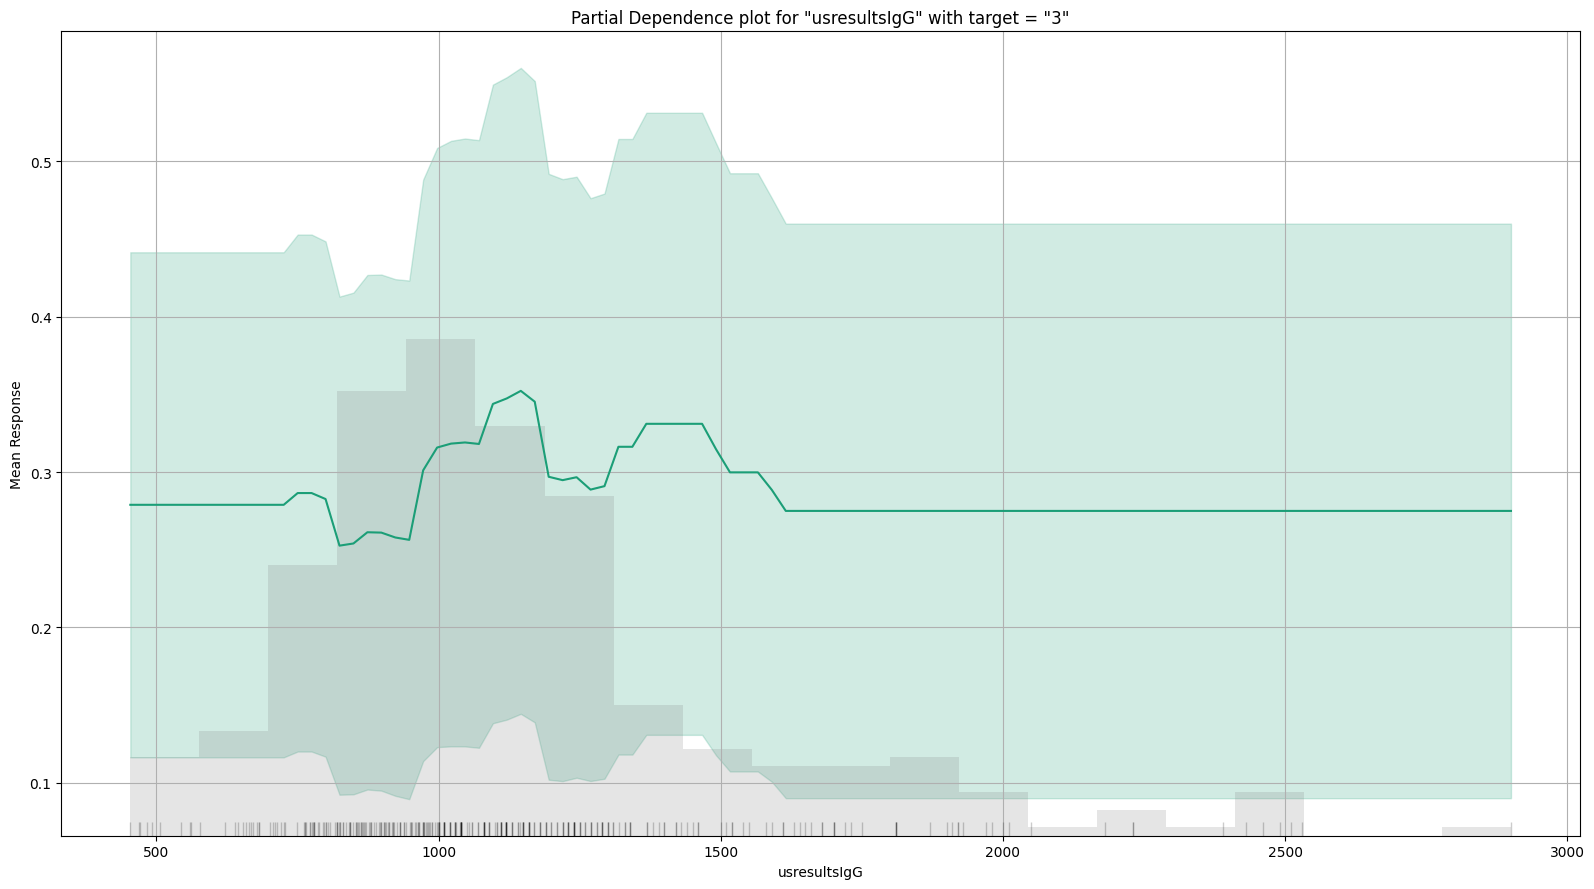

In [21]:
exm = aml.leader.explain(test)


In [22]:
varimp = aml.varimp(use_pandas=True)
varimp

,GBM_grid_1_model_1,GLM_1,DeepLearning_1,DeepLearning_grid_3_model_1,DeepLearning_grid_2_model_1,DeepLearning_grid_1_model_1,GBM_1,GBM_grid_1_model_2,XGBoost_grid_1_model_3,XRT_1,DRF_1,GBM_4,GBM_5,GBM_3,GBM_2,XGBoost_grid_1_model_2,XGBoost_grid_1_model_1,XGBoost_2,XGBoost_3,XGBoost_1
ndmardused,0.004467,0.020218,0.016551,0.021142,0.019979,0.018818,0.000000,0.020050,0.013805,0.021938,0.022668,0.025001,1.983773e-02,0.019726,0.017519,0.021779,0.007159,0.017876,0.017062,0.016217
drinker,0.024863,0.030004,0.008421,0.024424,0.023630,0.020650,0.003301,0.012318,0.009633,0.009392,0.011434,0.008431,6.081184e-03,0.007498,0.007015,0.006657,0.003653,0.006324,0.008432,0.008235
ara_func_class,0.014383,0.031982,0.022238,0.017652,0.018860,0.017926,0.011091,0.003211,0.012311,0.011857,0.015496,0.015783,1.525254e-02,0.010546,0.010966,0.011643,0.007258,0.007391,0.009291,0.008456
race_grp,0.017103,0.032354,0.019964,0.018571,0.020398,0.019391,0.014642,0.008068,0.008651,0.010853,0.010049,0.004631,1.195925e-02,0.007310,0.006239,0.006995,0.007322,0.005725,0.006848,0.002920
final_education,0.008385,0.011711,0.016859,0.022541,0.024308,0.021008,0.007082,0.005479,0.007813,0.014389,0.011850,0.013918,7.989522e-03,0.008643,0.007543,0.006520,0.011377,0.008081,0.012594,0.006863
hxtia,0.000000,0.020295,0.021842,0.014082,0.012318,0.013944,0.000000,0.000000,0.000000,0.000465,0.000940,0.000000,1.856133e-07,0.000359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pres_pred,0.008621,0.019784,0.021981,0.019145,0.020950,0.018364,0.003677,0.006601,0.007580,0.005096,0.007745,0.006035,5.267893e-03,0.011396,0.008810,0.005422,0.004922,0.004962,0.004996,0.004834
rfstatus_b,0.018871,0.022542,0.024144,0.018556,0.019935,0.021325,0.006543,0.004667,0.001799,0.007508,0.008543,0.006952,2.358367e-03,0.006886,0.003540,0.001687,0.002159,0.003410,0.002725,0.002087
nonpresNSAIDs_use,0.002702,0.008932,0.027262,0.022006,0.020299,0.019706,0.000925,0.004516,0.002341,0.006025,0.008837,0.007716,3.662932e-03,0.006628,0.004887,0.006521,0.000671,0.007026,0.008337,0.003855
pres_imuran,0.000000,0.003423,0.019960,0.016549,0.014644,0.017546,0.000000,0.000000,0.000000,0.001495,0.002061,0.000000,6.464499e-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
preds = aml.leader.predict(test)


xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [24]:
df = test.cbind(preds)

#preview
df.head(10)


grp,init_group,age,gender,final_education,race_grp,ethnicity,BMI,height,newsmoker,drinker,drinksperwk,duration_ra,ara_func_class,num_tnf,num_nontnf,ndmardused,rfstatus_b,usresultsRF,usresultsCCP3,hxmi,hxunstab_ang,hxchf,hxother_cv,hxtia,hxstroke,hxcopd,hxhtn,hxdiabetes,hxhld,hx_anycancer,seatedbp1,seatedbp2,pres_mtx,pres_arava,pres_azulfidine,pres_plaquenil,pres_imuran,pres_minocin,pres_pred,nonpresNSAIDs_use,NSAIDs_use,md_global_assess,di,usresultsIgA,usresultsIgG,usresultsIgM,tender_jts_28_0,swollen_jts_28_0,pt_global_assess_0,usresultsCRP_0,response_encoded,predict,p1,p2,p3
4,0,51,0,0,7,1,20.2204,68,2,1,0.233333,9,2,1,0,2,1,339.8,251,0,0,0,0,0,0,0,0,0,0,0,140,90,0,0,0,0,0,0,1,1,0,70,1.28571,469,1260,114,8,10,90,5.56,2,2,0.229689,0.554653,0.215658
6,0,63,0,0,7,1,20.939,64,0,1,3,5,1,1,1,2,0,8.2,15,0,0,0,0,0,0,0,0,0,0,0,113,68,1,0,0,0,0,0,1,0,1,35,0,179,1210,176,4,8,70,0.19,3,2,0.408851,0.439574,0.151574
4,0,47,0,2,7,1,24.8865,64,1,1,1,22,1,2,0.233333,1,1,144.7,251,0,0,0,0,0,0,0,0,0,0,0,144,83,0,0,0,0,0,0,0,0,0,45,0.5,177,1250,313,8,9,42,15.99,3,1,0.459051,0.172179,0.36877
4,0,80,0,2,7,0.966667,23.2381,61,2,1,7,9,2,2,0.333333,2,1,19.6,240,0,0,0,0,0,0,0,0,0,0,0,120,70,1,0,0,0,0,0,1,0,1,70,1,289,1240,128,3,15,90,5.67,2,2,0.19368,0.486181,0.320139
0,0,57,1,0,7,1,30.4066,68,0,0,0,2,1,2,0.5,1,1,17,82.5,0,0,0,0,0,0,0,0,0,0,0,128,82,1,0,0,0,0,0,1,1,0,45,0,325,721,31,16,5,35,4.24,1,3,0.291813,0.232055,0.476132
2,1,54,0,0,7,1,28.2427,66,2,1,2,2,0,0,0,1,1,16.8,15,0,0,0,0,0,0,0,0,0,0,0,108,69,0,0,0,0,0,0,0,0,0,35,0.25,207,1010,56,3,3,17,1.19,1,3,0.329826,0.114459,0.555715
2,1,54,0,2,7,1,26.6225,65,0,0,0,3,1,0,0,2,1,28.8,251,0,0,0,0,0,0,0,0,0,0,0,140,82,0,0,0,0,0,0,0,1,0,65,0.75,462,939,49,7,7,70,51.51,2,2,0.0595523,0.57826,0.362188
5,1,57,0,0,7,1,30.4174,61,2,0,0,3,1,0,0,1,1,110.2,251,0,0,0,0,0,0,0,1,0,1,0,132,79,1,0,0,0,0,0,1,0,0,70,1,273,714,138,9,9,55,10.4763,3,2,0.271819,0.384457,0.343724
0,0,43,0,0,7,1,27.454,63,1,0,0,11,0,1,0,1,0,10.7,170,0,0,0,0,0,0,0,0,1,0,0,130,80,1,0,0,0,0,0,1,1,0,80,2.125,144,836,86,4,0,80,4.11,2,1,0.752213,0.123005,0.124782
4,0,50,0,0,7,1,35.5051,66,2,1,0.233333,4,1,3,0,1,1,28.7,119,0,0,0,0,0,0,0,0,0,0,0,120,70,1,0,0,0,0,0,1,0,1,51,0.5,280,1250,354,2,6,65,6.29,3,1,0.701705,0.191703,0.106592


In [25]:
df = h2o.as_list(df)


In [26]:
preds = df[['response_encoded', 'predict']].head(20)
preds

,response_encoded,predict
0,2,2
1,3,2
2,3,1
3,2,2
4,1,3
5,1,3
6,2,2
7,3,2
8,2,1
9,3,1


In [27]:
!pip install lime
import lime
import lime.lime_tabular

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=af2a17480037525955e0ebeefba4900e452ec87ba4039700c6cdada1fdd88211
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [28]:
feature_names = train.columns[0: -1]
# feature_names.remove('response_status')
# feature_names_2 = np.delete(feature_names, np.where(feature_names == 'response_status'))
# # feature_names = feature_names.flatten()

# feature_names_2 = feature_names_2.tolist()
feature_names

['grp',
 'init_group',
 'age',
 'gender',
 'final_education',
 'race_grp',
 'ethnicity',
 'BMI',
 'height',
 'newsmoker',
 'drinker',
 'drinksperwk',
 'duration_ra',
 'ara_func_class',
 'num_tnf',
 'num_nontnf',
 'ndmardused',
 'rfstatus_b',
 'usresultsRF',
 'usresultsCCP3',
 'hxmi',
 'hxunstab_ang',
 'hxchf',
 'hxother_cv',
 'hxtia',
 'hxstroke',
 'hxcopd',
 'hxhtn',
 'hxdiabetes',
 'hxhld',
 'hx_anycancer',
 'seatedbp1',
 'seatedbp2',
 'pres_mtx',
 'pres_arava',
 'pres_azulfidine',
 'pres_plaquenil',
 'pres_imuran',
 'pres_minocin',
 'pres_pred',
 'nonpresNSAIDs_use',
 'NSAIDs_use',
 'md_global_assess',
 'di',
 'usresultsIgA',
 'usresultsIgG',
 'usresultsIgM',
 'tender_jts_28_0',
 'swollen_jts_28_0',
 'pt_global_assess_0',
 'usresultsCRP_0']

In [29]:
train_features_numpy = train[feature_names].as_data_frame().values
train_features_numpy

array([[ 4.  ,  0.  , 59.  , ...,  6.  , 55.  , 17.13],
       [ 2.  ,  1.  , 54.  , ...,  4.  , 25.  ,  1.64],
       [ 0.  ,  0.  , 67.  , ..., 10.  , 40.  ,  0.43],
       ...,
       [ 3.  ,  1.  , 61.  , ...,  5.  , 15.  ,  0.92],
       [ 2.  ,  1.  , 57.  , ...,  6.  , 50.  , 12.67],
       [ 1.  ,  1.  , 23.  , ...,  4.  , 93.  ,  3.9 ]])

In [30]:
#define LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(train_features_numpy, 
                                                   feature_names = feature_names,
                                                   mode='classification')

In [31]:
def findPrediction(instance):

 #instance will be in type of numpy
 df = pd.DataFrame(data = instance, columns = feature_names)
 hf = h2o.H2OFrame(df)
 predictions = aml.leader.predict(hf).as_data_frame()
 
 #here predictions object is 3 columned data frame. 1st column is class prediction and others are probabilities
 #lime needs just prediction probabilities
 
 predictions = predictions.iloc[:,1:].values
 return predictions

In [32]:
idx = 100
test_df = test.as_data_frame()
test_numpy = test_df.iloc[idx].values[0:-1]

In [33]:

test_numpy = np.delete(test_numpy, np.where(test_numpy == 'No Response'))
test_numpy


<ipython-input-33-a33a13b8d92e>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  test_numpy = np.delete(test_numpy, np.where(test_numpy == 'No Response'))


array([4.00000000e+00, 0.00000000e+00, 5.60000000e+01, 1.00000000e+00,
       2.00000000e+00, 7.00000000e+00, 1.00000000e+00, 3.57332493e+01,
       6.90000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.20000000e+01, 1.00000000e+00, 3.00000000e+00, 2.00000000e+00,
       2.00000000e+00, 1.00000000e+00, 7.50000000e+02, 2.51000000e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.20000000e+02,
       8.00000000e+01, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.00000000e+01, 1.00000000e+00,
       2.99000000e+02, 1.17000000e+03, 1.42000000e+02, 1.00000000e+01,
       3.00000000e+00, 9.00000000e+01, 2.57000000e+00])

In [34]:
exp = explainer.explain_instance(test_numpy, 
                                 findPrediction, 
                                 num_features = len(feature_names))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [35]:
exp.show_in_notebook(show_table=True, show_all=True)


In [36]:
exp.as_list()


[('swollen_jts_28_0 <= 4.00', -0.09857640544152768),
 ('pt_global_assess_0 > 70.00', 0.08110992702631697),
 ('BMI > 34.38', -0.0763482299895332),
 ('1.54 < usresultsCRP_0 <= 4.09', -0.05377635927035811),
 ('116.00 < seatedbp1 <= 125.00', 0.05233338231387017),
 ('usresultsRF > 110.20', 0.048693316816276686),
 ('ara_func_class <= 1.00', -0.03621036734736712),
 ('1072.77 < usresultsIgG <= 1280.00', -0.03515219005042979),
 ('107.00 < usresultsIgM <= 151.00', 0.034817988863780215),
 ('3.00 < grp <= 4.00', -0.03223778887033881),
 ('0.00 < final_education <= 2.00', -0.025443987990418745),
 ('76.00 < seatedbp2 <= 82.00', -0.025262924793527684),
 ('6.00 < tender_jts_28_0 <= 10.00', -0.02452764167796304),
 ('232.00 < usresultsIgA <= 311.00', -0.02402117460007124),
 ('0.50 < di <= 1.00', 0.02391845123789241),
 ('newsmoker <= 1.00', -0.021539607051927985),
 ('drinksperwk <= 0.00', 0.021176996816252985),
 ('pres_arava <= 0.00', 0.020855664867710552),
 ('49.00 < age <= 58.00', 0.019383693370387707),

In [ ]:
import lime
import lime.lime_tabular
feature_names = train_data.columns[0: -1]
feature_names
train_features_numpy = train_data[feature_names].as_data_frame().values

#define LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(train_features_numpy, 
                                                   feature_names = feature_names,
                                                   mode='classification')

In [ ]:
def findPrediction(instance):

 #instance will be in type of numpy
 df = pd.DataFrame(data = instance, columns = feature_names)
 hf = h2o.H2OFrame(df)
 predictions = aml.leader.predict(hf).as_data_frame()
 
 #here predictions object is 3 columned data frame. 1st column is class prediction and others are probabilities
 #lime needs just prediction probabilities
 
 predictions = predictions.iloc[:,1:].values
 return predictions

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=350, max_depth=6)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=350)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=[0, 1, 2, 3], mode='classification')
exp = explainer.explain_instance(X_test.iloc[0], clf.predict_proba, num_features=10)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
clf.predict_proba

<bound method ForestClassifier.predict_proba of RandomForestClassifier(max_depth=6, n_estimators=350)>

In [ ]:
print(exp.as_list())


[('drinker_not <= 0.00', -0.01841890670984577), ('drinksperwk > 2.00', -0.017635574593095556), ('0.00 < grp_orencia <= 1.00', 0.017544886298168073), ('pt_global_assess_0 <= 37.00', 0.016146843861896784), ('usresultsCRP_0 <= 1.54', 0.013978172324099456), ('tender_jts_28_0 <= 6.00', 0.013471757098285984), ('swollen_jts_28_0 > 10.00', -0.011880634596210136), ('race_grp_Unknown <= 0.00', 0.011155200617385452), ('Type I IFN activity <= 0.00', 0.010965226005509875), ('hx_anycancer <= 0.00', 0.010653752661972668)]


1. swollen_jts_28_0 (0.05269)
2. tender_jts_28_0 (0.05102)
3. usresultsCRP_0 (0.04956)
4. BMI (0.04763)
5. usresultsRF (0.04697)
6. di (0.04692)
7. pt_global_assess_0 (0.04006)
8. md_global_assess (0.03823)
9. usresultsIgG (0.03815)
10. usresultsIgA (0.03814)
11. usresultsIgM (0.03716)
12. seatedbp2 (0.03229)
13. seatedbp1 (0.03212)
14. drinksperwk (0.03150)
15. age (0.03037)
16. rfstatus_b (0.02823)
17. duration_ra (0.02693)
18. height (0.02392)
19. usresultsCCP3 (0.02302)
20. grp_orencia (0.02027)
21. num_tnf (0.01639)
22. smkyrs (0.01570)
23. Type I IFN activity (0.01363)
24. numcigs (0.01257)
25. ndmardused (0.01255)
26. drinker_yes (0.00808)
27. ara_func_class_III (0.00787)
28. init_group_bionaive TNF (0.00762)
29. race_grp_White (0.00704)
30. pres_pred (0.00687)
31. ara_func_class_I (0.00620)
32. grp_humira (0.00609)
33. ara_func_class_II (0.00590)
34. num_nontnf (0.00575)
35. drinker_not (0.00560)
36. init_group_bioexp nTNF (0.00558)
37. grp_actemra (0.00553)
38. newsmoker_never

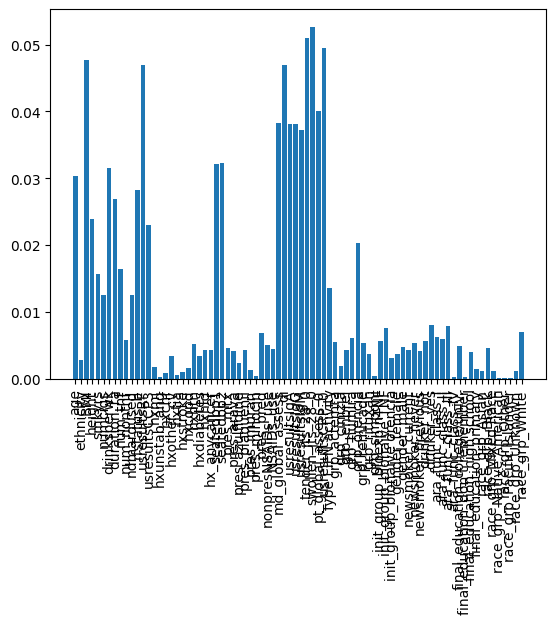

In [ ]:
importance = clf.feature_importances_
# create a list of feature names
feature_names = list(X_train.columns)
# create a dictionary mapping feature names to importances
feature_importances = dict(zip(feature_names, importance))
# sort features by importance in descending order
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
# print feature importances in descending order
for i, (feature, score) in enumerate(sorted_features):
    print("{}. {} ({:.5f})".format(i+1, feature, score))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(range(len(importance)), feature_names, rotation=90)
plt.show()